In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 資料路徑與基本參數
data_dir = 'English/Fnt'
image_size = (64, 64)
num_classes = 62

# 修正的標籤對應字母數字的對照表
def label_to_char(label):
    if label < 10:  # 數字 0-9
        return chr(label + 48)
    elif 10 <= label < 36:  # 大寫字母 A-Z
        return chr(label + 55)
    else:  # 小寫字母 a-z
        return chr(label + 61)

# 加載圖像和標籤
def load_image_and_label(file_path, label, original_index):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    return image / 255.0, label, original_index

# 創建數據集並記錄原始索引
def create_dataset_list():
    images, labels, original_indices, filenames = [], [], [], []
    for folder in sorted(os.listdir(data_dir)):
        if not folder.startswith('Sample'):
            continue
        label = int(folder.replace('Sample', '')) - 1
        folder_path = os.path.join(data_dir, folder)
        for i, file in enumerate(sorted(os.listdir(folder_path))):
            file_path = os.path.join(folder_path, file)
            images.append(file_path)
            labels.append(label)
            original_indices.append(len(filenames))
            filenames.append(file_path)
    return images, labels, original_indices, filenames

# 使用多線程加載圖像
def load_data_multithread(images, labels, original_indices, num_threads=8):
    x_data, y_data, indices = [], [], []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = executor.map(load_image_and_label, images, labels, original_indices)
        for img, lbl, idx in results:
            x_data.append(img)
            y_data.append(lbl)
            indices.append(idx)
    return np.array(x_data), np.array(y_data), indices

# 加載數據
images, labels, original_indices, filenames = create_dataset_list()
x_data, y_data, original_indices = load_data_multithread(images, labels, original_indices)

# 調整數據格式
x_data = x_data.reshape(-1, 64, 64, 1).astype('float32')
y_data = tf.keras.utils.to_categorical(y_data, num_classes=num_classes)

# 分割資料
x_train, x_test, y_train, y_test, train_original_indices, test_original_indices = train_test_split(
    x_data, y_data, original_indices, test_size=0.2, random_state=42
)

print(f"Data loaded successfully: {x_data.shape}, {y_data.shape}")

Data loaded successfully: (62992, 64, 64, 1), (62992, 62)


In [2]:
# 確認每個標籤對應的資料夾
def verify_label_folder_mapping():
    for label in range(num_classes):
        folder = f"Sample{str(label + 1).zfill(3)}"
        expected_files = [f for f in filenames if folder in f]
        print(f"Label: {label} ({label_to_char(label)}) -> Folder: {folder}, Files: {len(expected_files)}")

# 隨機顯示樣本
def show_random_samples(n=5):
    print("Random Samples:")
    for _ in range(n):
        idx = np.random.randint(0, len(x_data))
        char = label_to_char(np.argmax(y_data[idx]))
        print(f"Index: {idx}, File: {filenames[idx]}, Label: {char}")
        plt.imshow(x_data[idx].reshape(*image_size), cmap='gray')
        plt.title(f"Index: {idx}, Label: {char}\nFile: {filenames[idx]}")
        plt.axis('off')
        plt.show()

# 顯示指定索引的樣本
def show_sample_by_index(index):
    char = label_to_char(np.argmax(y_data[index]))
    print(f"Index: {index}, File: {filenames[index]}, Label: {char}")
    plt.imshow(x_data[index].reshape(*image_size), cmap='gray')
    plt.title(f"Index: {index}, Label: {char}\nFile: {filenames[index]}")
    plt.axis('off')
    plt.show()

# 驗證數據
verify_label_folder_mapping()

Label: 0 (0) -> Folder: Sample001, Files: 1016
Label: 1 (1) -> Folder: Sample002, Files: 1016
Label: 2 (2) -> Folder: Sample003, Files: 1016
Label: 3 (3) -> Folder: Sample004, Files: 1016
Label: 4 (4) -> Folder: Sample005, Files: 1016
Label: 5 (5) -> Folder: Sample006, Files: 1016
Label: 6 (6) -> Folder: Sample007, Files: 1016
Label: 7 (7) -> Folder: Sample008, Files: 1016
Label: 8 (8) -> Folder: Sample009, Files: 1016
Label: 9 (9) -> Folder: Sample010, Files: 1016
Label: 10 (A) -> Folder: Sample011, Files: 1016
Label: 11 (B) -> Folder: Sample012, Files: 1016
Label: 12 (C) -> Folder: Sample013, Files: 1016
Label: 13 (D) -> Folder: Sample014, Files: 1016
Label: 14 (E) -> Folder: Sample015, Files: 1016
Label: 15 (F) -> Folder: Sample016, Files: 1016
Label: 16 (G) -> Folder: Sample017, Files: 1016
Label: 17 (H) -> Folder: Sample018, Files: 1016
Label: 18 (I) -> Folder: Sample019, Files: 1016
Label: 19 (J) -> Folder: Sample020, Files: 1016
Label: 20 (K) -> Folder: Sample021, Files: 1016
La

Epoch 1/20
788/788 [==============================] - 15s 9ms/step - loss: 1.4415 - accuracy: 0.6070 - val_loss: 0.5676 - val_accuracy: 0.8142 - lr: 0.0010
Epoch 2/20
788/788 [==============================] - 6s 8ms/step - loss: 0.6553 - accuracy: 0.7877 - val_loss: 0.4467 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 3/20
788/788 [==============================] - 6s 8ms/step - loss: 0.5473 - accuracy: 0.8143 - val_loss: 0.3827 - val_accuracy: 0.8607 - lr: 0.0010
Epoch 4/20
788/788 [==============================] - 7s 8ms/step - loss: 0.4874 - accuracy: 0.8290 - val_loss: 0.3496 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 5/20
788/788 [==============================] - 6s 8ms/step - loss: 0.4426 - accuracy: 0.8397 - val_loss: 0.3212 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 6/20
788/788 [==============================] - 6s 8ms/step - loss: 0.4187 - accuracy: 0.8445 - val_loss: 0.3098 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 7/20
788/788 [==============================] - 6s 8ms/step - l

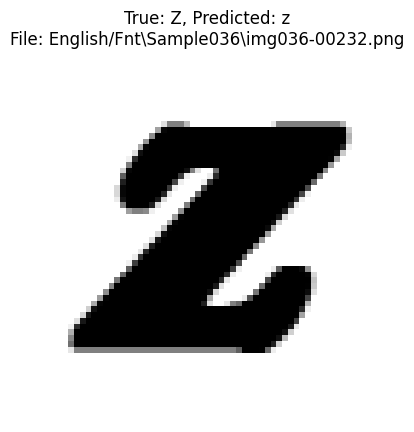

Test Index: 32, Original Index: 33369, True Label: W, Predicted: w, File: English/Fnt\Sample033\img033-00858.png


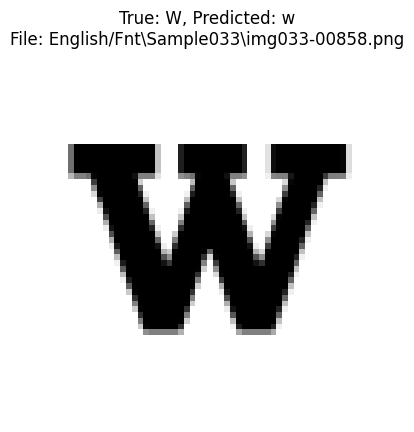

Test Index: 39, Original Index: 31167, True Label: U, Predicted: u, File: English/Fnt\Sample031\img031-00688.png


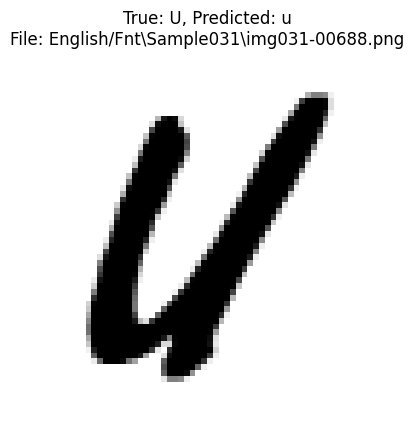

Test Index: 45, Original Index: 39150, True Label: c, Predicted: C, File: English/Fnt\Sample039\img039-00543.png


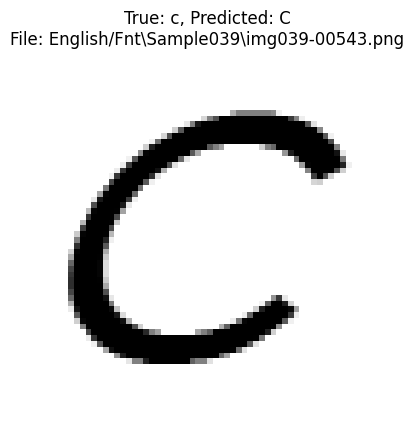

Test Index: 56, Original Index: 33955, True Label: X, Predicted: x, File: English/Fnt\Sample034\img034-00428.png


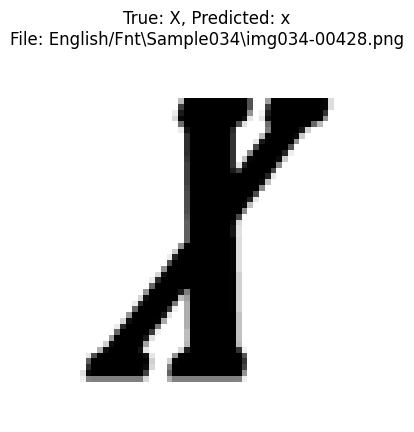

In [3]:
# CNN 模型
def build_cnn_model(input_shape=(64, 64, 1), num_classes=62):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# 建立 CNN 模型
model = build_cnn_model(input_shape=(64, 64, 1), num_classes=62)

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


# 訓練模型
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping]
)

# 評估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%")

# 顯示錯誤樣本及其原始索引
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

incorrect_indices = np.where(predicted_labels != true_labels)[0]

print("Incorrect Samples:")
for idx in incorrect_indices[:5]:
    original_index = test_original_indices[idx]
    true_char = label_to_char(true_labels[idx])
    pred_char = label_to_char(predicted_labels[idx])
    print(f"Test Index: {idx}, Original Index: {original_index}, True Label: {true_char}, Predicted: {pred_char}, File: {filenames[original_index]}")
    plt.imshow(x_test[idx].reshape(64, 64), cmap='gray')
    plt.title(f"True: {true_char}, Predicted: {pred_char}\nFile: {filenames[original_index]}")
    plt.axis('off')
    plt.show()


In [4]:
model.save('Final_character_recognition_model_64x64.h5')

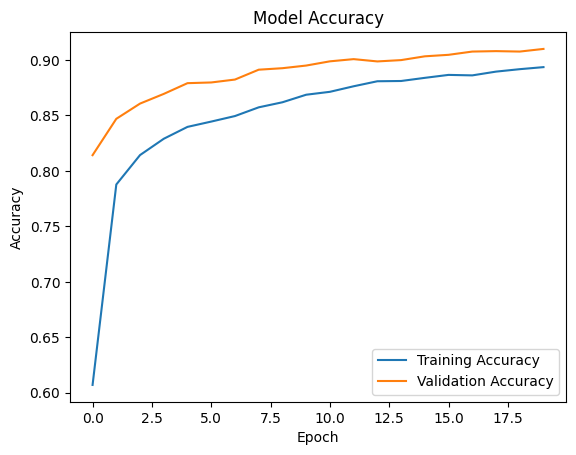

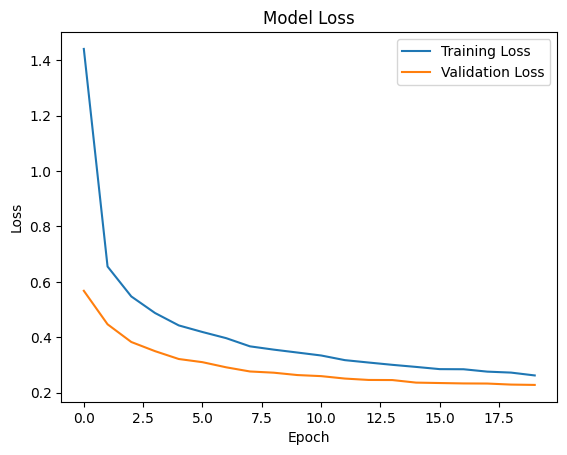

In [5]:
import matplotlib.pyplot as plt

# 繪製準確率曲線
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 繪製損失曲線
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
